# Code to prepare data from arrythmia dataset

## Detailed description
The arrythmia dataset contains diagnoses in the `.hea` file for each ECG as a diagnosis code (with the mapping from diagnosis codes to condition names and abbreviations stored in `ConditionNames_SNOMED-CT.csv`). This is not ideal to work with, so instead we create `arrythmia_dataset.pickle` with a dataframe of all the data, organized into a table with the following format:

|        | rec_id  | wf                                               | AFIB | RBBB | TWC | ... | AVRT | SA |
|--------|---------|--------------------------------------------------|------|------|-----|-----|------|----|
| 0      | JS00001 | [[-0.254, 0.264, 0.517, -0.005, -0.386, 0.39, ... | 1    | 1    | 1   | ... | 0    | 0  |
| 1      | JS00002 | [[-0.01, 0.01, 0.02, 0.0, -0.015, 0.015, -0.01... | 0    | 0    | 1   | ... | 0    | 0  |
| 2      | JS00004 | [[0.195, 0.107, -0.088, -0.151, 0.142, 0.01, -... | 0    | 0    | 0   | ... | 0    | 0  |
| 3      | JS00005 | [[0.005, -0.146, -0.151, 0.073, 0.078, -0.151,... | 0    | 0    | 0   | ... | 0    | 0  |
| 4      | JS00006 | [[-0.029, -0.068, -0.039, 0.049, 0.005, -0.054... | 0    | 0    | 0   | ... | 0    | 0  |


Here, `rec_id` is the ECG name, `wf` is the raw `(5000, 12)` 12-lead ECG (sampled for 10s at 500Hz) and `AFIB,...,SA` are the 52 labeled conditions, with `1` indicating the presence of the condition, and `0` its absence. We also remove `wf` entries with `NaN` values or an unreadable `.hea` file (total of 99 records, out of 45,152).

In [1]:
import pandas as pd
import numpy as np
import wfdb
import os
from tqdm import tqdm
import re 
from utils import get_arrythmia_path

/tmp/ipykernel_68779/105588533.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load the condition -> diagnosis number mappings (to reference with `.hea` files)

In [2]:
dataset_path = "/cis/home/charr165/Documents/physionet.org/files/ecg-arrhythmia/1.0.0"

f_path = os.path.join(dataset_path, 'ConditionNames_SNOMED-CT.csv')
cond_names_df = pd.read_csv(f_path)

Get all the `WFDBRecords` (`rec_id` and corresponding path) contained in the `arrythmia_path` (specified in `config.json`).

In [3]:
records_path = os.path.join(dataset_path, 'WFDBRecords')

record_paths_dict = {'rec_id': [], 'rec_path': []}

# List all folders in the records path
first_lvl_dirs = os.listdir(records_path)
first_lvl_dirs = [f for f in first_lvl_dirs if os.path.isdir(os.path.join(records_path, f))]

for first_lvl_dir in first_lvl_dirs:
    second_lvl_dirs = os.listdir(os.path.join(records_path, first_lvl_dir))
    second_lvl_dirs = [f for f in second_lvl_dirs if os.path.isdir(os.path.join(records_path, first_lvl_dir, f))]

    for second_lvl_dir in second_lvl_dirs:
        # Get all .hea files in the second level directory
        f_path = os.path.join(records_path, first_lvl_dir, second_lvl_dir)
        files = os.listdir(f_path)
        hea_files = [f for f in files if f.endswith('.hea')]

        for f in hea_files:
            record_name = f.split('.')[0]
            record_paths_dict['rec_id'].append(record_name)
            record_paths_dict['rec_path'].append(os.path.join(records_path, first_lvl_dir, second_lvl_dir, record_name))

records_path_df = pd.DataFrame(record_paths_dict)

print(f"Total number of records: {len(records_path_df)}")

Total number of records: 45152


Functions to read into record info (from `.hea` files) and waveforms (from `.mat` files).

In [4]:
def get_record_info(record_path):
    record = wfdb.rdrecord(record_path)
    rec_id = record.record_name
    comments = record.comments

    age, sex, dx, dx_nums = None, None, None, None
    for comment in comments:
        if 'Age' in comment:
            match = re.search(r'Age: (\d+)', comment)
            if match:
                age = int(match.group(1))

        if 'Sex' in comment:
            if 'Male' in comment:
                sex = 'M'
            elif 'Female' in comment:
                sex = 'F'
        
        if "Dx: " in comment:
            match = re.findall(r'\d+', comment.replace(',', ' '))
            if match:
                dx_nums = [int(num) for num in match]

    if dx_nums is not None:
        dx = []
        for num in dx_nums:
            curr_cond = cond_names_df[cond_names_df['Snomed_CT'] == num]
            curr_dx = {}
            if curr_cond.empty:
                curr_dx['acronym'] = None
                curr_dx['name'] = None
                curr_dx['num'] = num
            else:
                curr_dx['acronym'] = curr_cond['Acronym Name'].values[0]
                curr_dx['name'] = curr_cond['Full Name'].values[0]
                curr_dx['num'] = num
            
            dx.append(curr_dx)

    return rec_id, age, sex, dx

def get_record_wf(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal

Get the sex, age, and diagnoses name/abbreviation for each ECG

In [5]:
n_fails = 0
records_info = pd.DataFrame()
for rec_path in tqdm(records_path_df['rec_path'], total=records_path_df.shape[0]):
    try:
        rec_id, age, sex, dxs = get_record_info(rec_path)
        for dx in dxs:
            tmp_dict = {'rec_id': rec_id, 'age': age, 'Dx_acronym': dx['acronym'], 'Dx_name': dx['name'], 'Dx_num': dx['num'],}
            records_info = pd.concat([records_info, pd.DataFrame(tmp_dict, index=[0])], ignore_index=True)
    except:
        n_fails += 1
        print(f'Failed to process record: {rec_path}')

print(f'Failed to process {n_fails} records')

  2%|▏         | 1012/45152 [00:10<07:03, 104.16it/s]

Failed to process record: /cis/home/charr165/Documents/physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords/01/019/JS01052


 50%|█████     | 22695/45152 [04:39<03:36, 103.58it/s]

Failed to process record: /cis/home/charr165/Documents/physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords/23/236/JS23074


100%|██████████| 45152/45152 [09:32<00:00, 78.92it/s] 

Failed to process 2 records


Get labels for each ECG, such that the label is `1` if the condition is present, and `0` if not.

In [6]:
unique_conditions = records_info['Dx_acronym'].unique()

labels_df = pd.DataFrame(columns=['rec_id'] + unique_conditions.tolist())
rec_ids = records_info['rec_id'].unique()
labels_df['rec_id'] = rec_ids

for i, rec_id in tqdm(enumerate(rec_ids), total=len(rec_ids)):
    subject_labels = records_info[records_info['rec_id'] == rec_id]

    for condition in unique_conditions:
        if condition in subject_labels['Dx_acronym'].values:
            labels_df.at[i, condition] = 1
        else:
            labels_df.at[i, condition] = 0

# labels_df['GSVT'] = labels_df['SVT'] + labels_df['AT'] + labels_df['AVNRT'] + labels_df['AVRT'] + labels_df['SAAWR']
print(labels_df)

100%|██████████| 45150/45150 [03:15<00:00, 230.68it/s]

        rec_id AFIB RBBB TWC SB AF STDD STTC SR None  ... WAVN JPT VB 2AVB1  \
0      JS00001    1    1   1  0  0    0    0  0    0  ...    0   0  0     0   
1      JS00002    0    0   1  1  0    0    0  0    0  ...    0   0  0     0   
2      JS00004    0    0   0  1  0    0    0  0    0  ...    0   0  0     0   
3      JS00005    0    0   0  0  1    1    1  0    0  ...    0   0  0     0   
4      JS00006    0    0   0  1  0    0    0  0    0  ...    0   0  0     0   
...        ...  ...  ...  .. .. ..  ...  ... ..  ...  ...  ...  .. ..   ...   
45145  JS45547    0    0   0  0  0    0    0  0    1  ...    0   0  0     0   
45146  JS45548    0    0   0  0  0    0    0  0    1  ...    0   0  0     0   
45147  JS45549    0    0   0  0  0    0    0  0    1  ...    0   0  0     0   
45148  JS45550    0    0   0  0  0    0    0  0    1  ...    0   0  0     0   
45149  JS45551    0    0   0  0  0    0    0  0    1  ...    0   0  0     0   

      VFW STE SVT AT AVRT SA  
0       0   0   0  0

Get `(5000,12)` dimensional waveforms for each ECG, as a `np` array.

In [7]:
n_fails = 0
records_wf = pd.DataFrame()
for i, rec_path in tqdm(enumerate(records_path_df['rec_path']), total=records_path_df.shape[0]):
    try:
        wf = get_record_wf(rec_path)
        tmp_dict = {'rec_id': records_path_df['rec_id'].iloc[i], 'wf': [wf]}
        records_wf = pd.concat([records_wf, pd.DataFrame(tmp_dict, index=[0])], ignore_index=True)
    except:
        n_fails += 1

print(f'Failed to process {n_fails} records')

100%|██████████| 45152/45152 [02:50<00:00, 264.15it/s]

Failed to process 2 records


Merge waveforms and conditions, then drop rows with any NaN waveforms (should be 97 rows in total with NaN values anywhere in the raw WF).

In [8]:
final_df = pd.merge(records_wf, labels_df, on='rec_id', how='inner')
final_df = final_df.sort_values(by='rec_id')
final_df.reset_index(drop=True, inplace=True)
print(f"Total records: {final_df.shape[0]}")
print(f"WF records: {records_wf.shape[0]}")
print(f"Labels records: {labels_df.shape[0]}")

# Iterate through final_df, and remove any records that have any nan in wf
nan_rows = []
for i, row in final_df.iterrows():
    if np.isnan(row['wf']).any():
        nan_rows.append(i)

final_df = final_df.drop(nan_rows)

print(f"Removed {len(nan_rows)} records with NaN values in wf")

final_df.head(5)

Total records: 45150
WF records: 45150
Labels records: 45150
Removed 97 records with NaN values in wf


,rec_id,wf,AFIB,RBBB,TWC,SB,AF,STDD,STTC,SR,...,WAVN,JPT,VB,2AVB1,VFW,STE,SVT,AT,AVRT,SA
0,JS00001,"[[-0.254, 0.264, 0.517, -0.005, -0.386, 0.39, ...",1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JS00002,"[[-0.01, 0.01, 0.02, 0.0, -0.015, 0.015, -0.01...",0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JS00004,"[[0.195, 0.107, -0.088, -0.151, 0.142, 0.01, -...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JS00005,"[[0.005, -0.146, -0.151, 0.073, 0.078, -0.151,...",0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,JS00006,"[[-0.029, -0.068, -0.039, 0.049, 0.005, -0.054...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save datafrmae to `arrythmia_dataset.pickle`.

In [9]:
# Save the final dataframe
os.makedirs('data', exist_ok=True)
final_df.to_pickle('data/arrythmia_dataset.pickle')

# Save the final dataframe
debug_df = final_df.head(2000)
debug_df.to_pickle('data/arrythmia_dataset_debug.pickle')

Reset abbreviations to full names for plotting frequencies.

In [10]:
new_labels = labels_df.copy()
abr_cols = new_labels.columns[1:].to_list()
full_names = []
for abr in abr_cols:
    if abr is None:
        full_names.append(None)
        continue

    full_name = cond_names_df[cond_names_df['Acronym Name'] == abr]['Full Name'].values[0]
    if full_name is None:
        full_name = abr
    full_names.append(full_name)
new_labels.columns = ['rec_id'] + full_names
labels_df = new_labels

Plot the frequency of each condition (for conditions that occur more than 1% of the time).

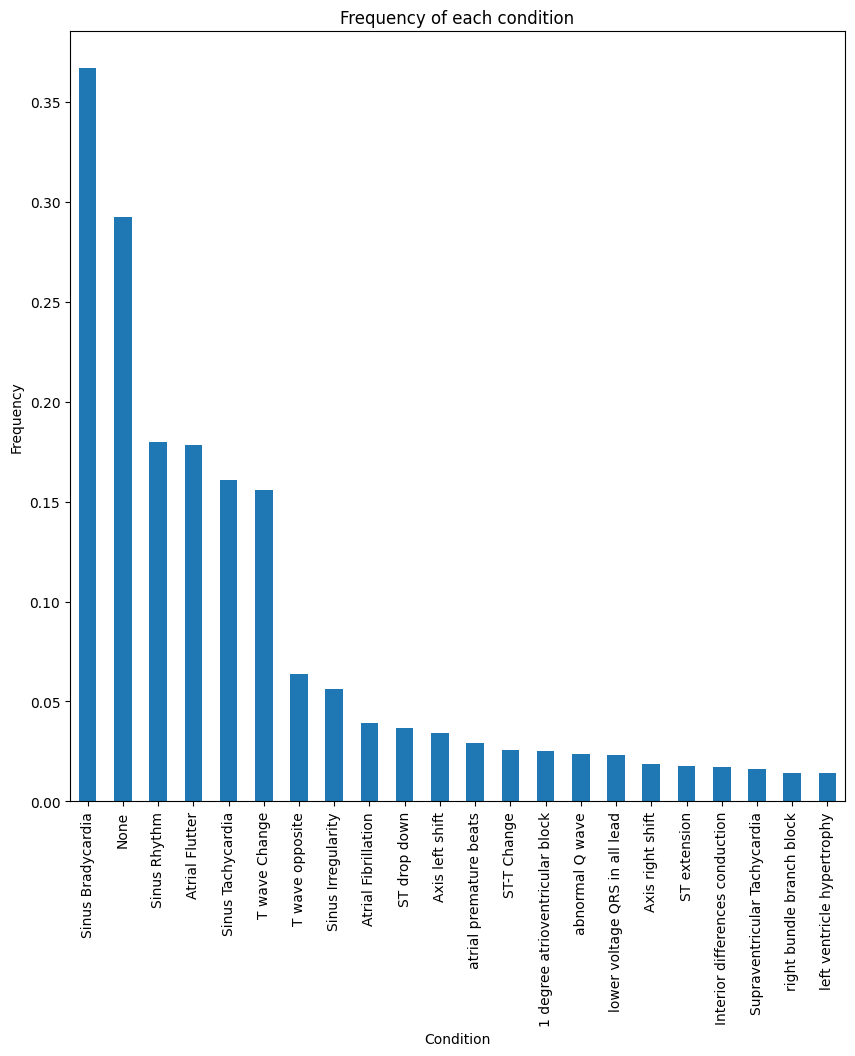

In [11]:
cols = labels_df.columns
cols = cols[1:]

# get the mean of each condition
mean = labels_df[cols].mean()
mean = mean[mean > 0.01]
# Sort the mean values
mean = mean.sort_values(ascending=False)

# Plot the mean of each condition
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
mean.plot(kind='bar')
plt.title('Frequency of each condition')
# Rotate the x labels
plt.xticks(rotation=90)
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.show()
